In [2]:
# Dependencies
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [3]:
wildfire = pd.read_csv('NOAA_csvs/wildfires_2010_2019.csv')
combo = pd.read_csv('NOAA_csvs/wf_combined_zone_county.csv')

In [4]:
# Drop undated fires.
combo.dropna(subset=['Date','County'],inplace=True)
# Group by NOAA FIP
combo.groupby("NOAA_FIP")
combo_counts = pd.DataFrame(combo["County"].value_counts())
combo_counts = combo_counts.reset_index()
combo_counts.rename(columns={"index":"County","County":"Fires"},inplace=True)
combo_counts = combo_counts.sort_values("Fires",ascending=False)
combo_counts.set_index("County")
combo_counts.reset_index(inplace=True)
combo_counts.drop(columns=["index"],inplace=True)
combo_counts

,County,Fires
0,San Bernardino,47
1,Riverside,45
2,Siskiyou,40
3,San Diego,30
4,Los Angeles,22
5,Modoc,19
6,Nevada,19
7,Ventura,19
8,Yuba,18
9,Amador,17


In [5]:
def rename_location(fire):
    name = fire.partition(" COUNTY")
    fire = str(name[0] + name[1])
    return fire
def filter_counties(list1, list2):
    return ([i for i in list1 if
             any(j in i for j in list2)])

In [6]:
# Variables for parsing lists.
fire = ""
new_names = []
chosen_names = []
substring = '(ZONE)'
county_names = [wildfire['CZ_NAME_STR']]


# Parses through both lists of counties and pulls out only shared values.
for fire in wildfire['CZ_NAME_STR']:
    fire = rename_location(fire)
    new_names.append(fire)
wildfire["CZ_NAME_STR"] = new_names
for name in new_names:
    if substring not in name:
        if name not in chosen_names:
            chosen_names.append(name.title())
for name in wildfire['CZ_NAME_STR']:
    county_names.append(name.title())
list1 = county_names
list2 = chosen_names
utile_counties = filter_counties(list1, list2)
for county in range(len(utile_counties)):
    utile_counties[county] = utile_counties[county].upper()

In [7]:
# Reduces NOAA data to rows found in the usable counties. (119 Fires in Ten Years)
clean_wf = pd.DataFrame()
clean_wf = wildfire[wildfire["CZ_NAME_STR"].isin(utile_counties)]
# Renames columns.
clean_wf = clean_wf[['EVENT_ID', 'CZ_NAME_STR', 'BEGIN_DATE', 'EVENT_TYPE', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 
                                'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM', 'CZ_FIPS']]
clean_wf.rename(columns={'EVENT_ID': 'NOAA ID', 
                                'CZ_NAME_STR': 'County Name', 
                                'BEGIN_DATE': 'Date', 
                                'EVENT_TYPE': 'Type', 
                                'DEATHS_DIRECT': 'Direct Deaths', 
                                'DEATHS_INDIRECT': 'Indirect Deaths', 
                                'INJURIES_DIRECT': 'Direct Injuries', 
                                'INJURIES_INDIRECT': 'Indirect Injuries', 
                                'DAMAGE_PROPERTY_NUM': 'Property Damage', 
                                'DAMAGE_CROPS_NUM': 'Crop Damage', 
                                'CZ_FIPS': 'NOAA_FIP'}, inplace=True)
clean_wf

,NOAA ID,County Name,Date,Type,Direct Deaths,Indirect Deaths,Direct Injuries,Indirect Injuries,Property Damage,Crop Damage,NOAA_FIP
0,234746,SAN BERNARDINO AND RIVERSIDE COUNTY,05/20/2010,Wildfire,0,0,0,1,0,0,48
1,250167,SAN DIEGO COUNTY,07/13/2010,Wildfire,0,0,0,0,0,0,43
2,250175,SAN BERNARDINO AND RIVERSIDE COUNTY,07/15/2010,Wildfire,0,0,1,0,17500,0,48
3,250169,RIVERSIDE COUNTY,07/15/2010,Wildfire,0,0,0,0,0,0,56
4,250171,SAN BERNARDINO AND RIVERSIDE COUNTY,07/15/2010,Wildfire,0,0,0,0,0,0,48
...,...,...,...,...,...,...,...,...,...,...,...
392,861476,VENTURA COUNTY,10/31/2019,Wildfire,0,0,0,0,0,0,45
393,863910,VENTURA COUNTY,11/01/2019,Wildfire,0,0,0,0,0,0,45
394,863913,VENTURA COUNTY,11/01/2019,Wildfire,0,0,0,0,0,0,44
395,863914,VENTURA COUNTY,11/01/2019,Wildfire,0,0,0,0,0,0,45


In [23]:
# # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html
# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%Y')

# data = clean_wf['Date']
# # with clean_wf as datafile:
# #     data = np.load(datafile)['Date']

# fig, ax = plt.subplots()
# ax.plot(clean_wf['Date'], clean_wf['County Name'], data=data)

# # format the ticks
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(years_fmt)
# ax.xaxis.set_minor_locator(months)

# # round to nearest years.
# datemin = np.datetime64(data['Date'][0], 'Y')
# datemax = np.datetime64(data['Date'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

# # format the coords message box
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
# ax.grid(True)

# # rotates and right aligns the x labels, and moves the bottom of the
# # axes up to make room for them
# fig.autofmt_xdate()

# plt.show()

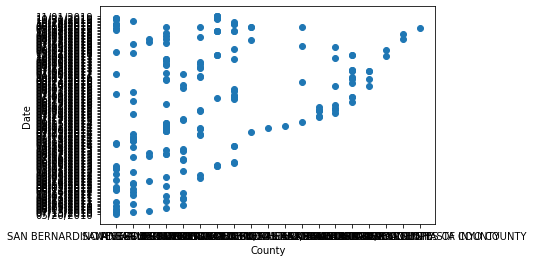

In [8]:
plt.scatter(clean_wf.iloc[:,1],clean_wf.iloc[:,2])
plt.xlabel('County')
plt.ylabel('Date')
plt.show()

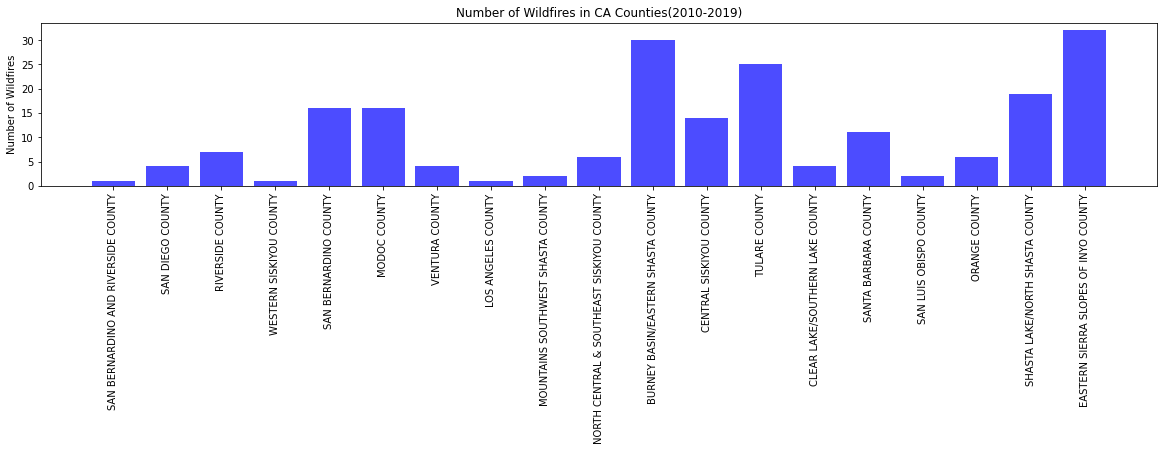

In [9]:
fires = clean_wf.groupby(clean_wf["County Name"])
f_county = clean_wf["County Name"].unique()
fire_ct = fires["County Name"].count()
f_tick_loc = [value for value in f_county]
plt.figure(figsize=(20,3))
plt.bar(f_county, fire_ct, color='b', alpha=0.7, align="center")
plt.xticks(f_tick_loc, f_county, rotation="vertical")
plt.title("Number of Wildfires in CA Counties(2010-2019)")
plt.ylabel("Number of Wildfires")
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

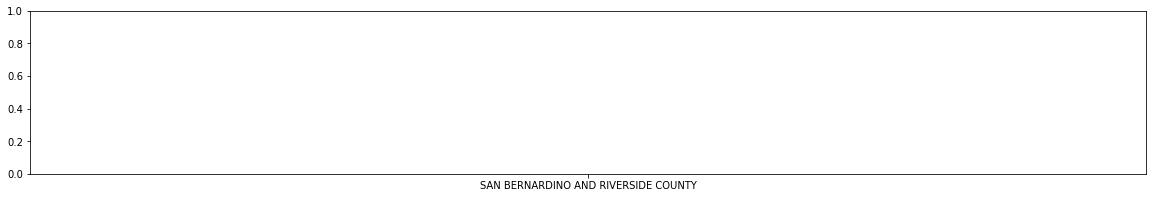

In [24]:
fires = clean_wf.groupby(clean_wf["County Name"])
f_county = clean_wf["County Name"].unique()
property_ct = clean_wf['Property Damage'].unique()
fp_tick_loc = [value for value in f_county]
plt.figure(figsize=(20,3))
plt.bar(f_county, property_ct, color='b', alpha=0.8, align="center")
plt.xticks(fp_tick_loc, f_county, rotation="vertical")
plt.title("Property Damage due to Wildfires in CA Counties(2010-2019)")
plt.ylabel("Property Damage")
plt.show()

In [10]:
clean_wf['Crop Damage'].value_counts()

0    201
Name: Crop Damage, dtype: int64

In [11]:
clean_wf['Property Damage'].value_counts()

0           152
100000        5
200000        3
500000        3
50000         3
400000        3
600000        2
900000        2
4000000       2
1000000       2
6000          2
7000000       1
17500         1
10000         1
2000000       1
3670000       1
20000         1
1120000       1
8000          1
8000000       1
25000000      1
1500000       1
25000         1
7240000       1
550000        1
5700000       1
56000000      1
30000000      1
50000000      1
15000         1
4000          1
20000000      1
22500000      1
Name: Property Damage, dtype: int64

In [12]:
clean_wf['Indirect Deaths'].value_counts()


0    197
1      4
Name: Indirect Deaths, dtype: int64

In [13]:
clean_wf['Direct Deaths'].value_counts()

0    186
1      8
3      4
2      2
4      1
Name: Direct Deaths, dtype: int64

In [14]:
clean_wf['Indirect Injuries'].value_counts()

0     182
3       6
4       3
2       3
1       3
12      2
10      1
5       1
Name: Indirect Injuries, dtype: int64

In [15]:
clean_wf['Direct Injuries'].value_counts()

0     175
1       9
3       4
2       4
4       3
8       2
21      1
18      1
12      1
5       1
Name: Direct Injuries, dtype: int64

In [20]:
county_count = clean_wf['County Name'].value_counts()
grouped_wf = clean_wf.groupby(['County Name'])

# summary_wf = pd.
# grouped_wf.count().head(10)

# # Using GroupBy in order to separate the data into fields according to "state" values
# grouped_usa_df = usa_ufo_df.groupby(['state'])

# # The object returned is a "GroupBy" object and cannot be viewed normally...
# print(grouped_usa_df)

# # In order to be visualized, a data function must be used...
# grouped_usa_df.count().head(10)

WESTERN SISKIYOU COUNTY                32
SAN BERNARDINO AND RIVERSIDE COUNTY    30
SAN DIEGO COUNTY                       25
VENTURA COUNTY                         19
MODOC COUNTY                           16
Name: County Name, dtype: int64

TypeError: unhashable type: 'numpy.ndarray'

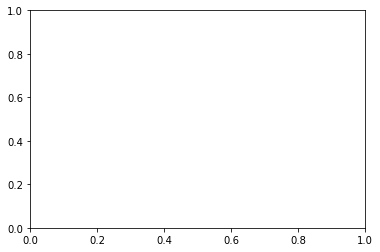

In [19]:
plt.scatter(grouped_wf['County Name'], clean_wf['Property Damage'])
plt.xlabel('County')
plt.ylabel('Property Damage')
plt.show()